## Library

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns


#geografi
#jika belum menginstall library di bawah hapus hashtag nya untuk menginstall library
!pip install folium matplotlib mapclassify
!pip install geodatasets
from folium.plugins import TimestampedGeoJson
import geopandas as gpd
import geodatasets
import folium
from folium.plugins import TimeSliderChoropleth
from geopy.geocoders import Nominatim

## Geografis Jakarta

In [4]:
kota = ['jakarta pusat','jakarta utara','jakarta timur',
        'jakarta selatan','jakarta barat','kepulauan seribu']
columns_drop = ['KDPPUM', 'KDPBPS', 'FCODE', 'LUASWH', 'UUPP',
       'SRS_ID','KDEBPS', 'KDEPUM', 'KDCBPS', 'KDCPUM',
       'KDBBPS', 'KDBPUM','WADMKD', 'WIADKD', 'WADMKC', 'WIADKC', 'WADMKK',
       'WIADKK', 'WADMPR', 'WIADPR', 'TIPADM','METADATA','REMARK','LCODE']
#buat dataframe kosong
geo_jakarta = pd.DataFrame()
#melakukan looping untuk tahun
for i in kota:
    try:
      #path adalah tempat data di simpan,
      #semua file di simpan di satu folder
      #gunakan nama yang sama kecuali tahun dan bulan nya
      path = f'/content/drive/MyDrive/Colab Notebooks/COMPFEST/Database/data_shape/{i}/ADMINISTRASIKECAMATAN_AR_25K.shp'
      data = gpd.read_file(path)
    except: continue
    data = data.drop(columns_drop,axis=1)
    #menambahkan kolom tahun
    data = data.assign(kota=i)
    data = data.rename(columns={'NAMOBJ':'kecamatan'})
    #menggabungkan data kedalam dataset data_kejadian_banjir
    geo_jakarta = pd.concat([geo_jakarta,data])

In [5]:
geo_jakarta.sample()

,kecamatan,SHAPE_Leng,SHAPE_Area,geometry,kota
7,Pesanggrahan,0.239991,0.001113,"POLYGON Z ((106.76699 -6.22518 0.00000, 106.76...",jakarta selatan


In [6]:
geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set1",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

### Lokasi Pintu Air

In [7]:
data_tinggi_air = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/data_tinggi_air.csv')

<ipython-input-7-e5cfb59b2a50>:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data_tinggi_air = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/data_tinggi_air.csv')


In [8]:
data_tinggi_air = data_tinggi_air.groupby(['tanggal','tahun','bulan','hari','nama_pintu_air',
                                     'lokasi', 'latitude', 'longitude'],
                                         sort=False).agg({'tinggi_air': 'mean',
                                                          'status_siaga': lambda x: x.mode()[0]}).reset_index()

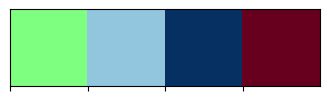

In [9]:
color_scale = np.array(['#7FFF7F','#92c5de','#053061','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [10]:
def color_coding(data):
  if data['status_siaga'] == 'normal':
    return color_scale[0]
  if data['status_siaga'] == 'siaga 1':
    return color_scale[1]
  if data['status_siaga'] == 'siaga 2':
    return color_scale[2]
  if data['status_siaga'] == 'siaga 3':
    return color_scale[3]

In [11]:
geo_data_tinggi_air = data_tinggi_air.copy()
geo_data_tinggi_air['color'] = geo_data_tinggi_air.apply(color_coding,axis=1)
geo_data_tinggi_air['tanggal'] = pd.to_datetime(geo_data_tinggi_air['tahun'].astype(str) + '-' + geo_data_tinggi_air['bulan'].astype(str) + '-1')

In [12]:
geo_data_tinggi_air.sample()

,tanggal,tahun,bulan,hari,nama_pintu_air,lokasi,latitude,longitude,tinggi_air,status_siaga,color
3770,2018-07-01,2018,7,13,p.a. hek,kali baru timur,-6.287305,106.87063,135.916667,siaga 3,#67001f


In [13]:
features_data_air = []
for _, row in geo_data_tinggi_air.iterrows():
  feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point',
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['tanggal'].date().__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 5
                },
                'popup':True,
                'tooltip':row['nama_pintu_air']
            }
        }
  features_data_air.append(feature)



In [14]:
m = geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set2",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)
TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features_data_air}
        , period='P1M'
        , add_last_point=True
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM'
        , time_slider_drag_update=True
    ).add_to(m)
folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m

Output hidden; open in https://colab.research.google.com to view.

### Lokasi Banjir

In [15]:
data_kejadian_banjir = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COMPFEST/hasil_dataset/data_kejadian_banjir.csv')

In [16]:
address = data_kejadian_banjir[['kota_administrasi','kelurahan']]

In [17]:
address.sample()

,kota_administrasi,kelurahan
1372,jakarta timur,kampung melayu


In [18]:
address['alamat'] = address['kelurahan'] + ',' + address['kota_administrasi']

<ipython-input-18-f42014bd14bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  address['alamat'] = address['kelurahan'] + ',' + address['kota_administrasi']


In [19]:
alamat = address['alamat'].unique()

In [20]:
geolocator = Nominatim(user_agent="my_app")
koordinat_kelurahan =[]
for kelurahan in alamat:
    location = geolocator.geocode(kelurahan)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
        koordinat_kelurahan.append((kelurahan, latitude, longitude))
    else:
        koordinat_kelurahan.append((kelurahan, None, None))

In [21]:
loc_kelurahan = pd.DataFrame(koordinat_kelurahan).rename(columns={0:'alamat',1:'latitude',2:'longitude'})

In [22]:
loc_kelurahan['longitude'].isna().sum()

0

In [23]:
loc_kelurahan['alamat'] = loc_kelurahan['alamat'].apply(lambda x: x.split(',')[0])

In [24]:
merged_df = pd.merge(data_kejadian_banjir, loc_kelurahan, left_on='kelurahan',right_on='alamat')

In [25]:
geo_kejadian_banjir = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df['longitude'], merged_df['latitude']))

In [26]:
m = geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set2",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

geo_kejadian_banjir.explore(
    m=m,  # pass the map object
    column="jumlah_banjir",
    color="red",  # use red color on all points
    marker_kwds=dict(radius= 5, fill=True),  # make marker radius 10px with fill
    tooltip="kelurahan",  # show "name" column in the tooltip
    tooltip_kwds=dict(labels=True),  # do not show column label in the tooltip
    popup=True,
    name="banjir",  # name of the layer in the map
)


folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m  # show map

Output hidden; open in https://colab.research.google.com to view.

In [27]:
geo_kejadian_banjir['tanggal'] = pd.to_datetime(geo_kejadian_banjir['tahun'].astype(str) + '-' + geo_kejadian_banjir['bulan'].astype(str) + '-1')

In [28]:
geo_kejadian_banjir.sample()

,kota_administrasi,kecamatan,kelurahan,rw,jumlah_terdampak_rw,ketinggian_air,tanggal_kejadian,lama_genangan,tahun,bulan,jumlah_banjir,alamat,latitude,longitude,geometry,tanggal
1277,jakarta selatan,pasar minggu,jati padang,rw 06,1.0,20 s/d 50 cm,"tgl. 06, 10 mei",0.0,2020,5,2,jati padang,-6.287241,106.830545,POINT (106.83054 -6.28724),2020-05-01


In [29]:
features_kejadian_banjir = []
for _, row in geo_kejadian_banjir.iterrows():
  feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point',
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['tanggal'].date().__str__(),
                'style': {'color' : 'red'},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': 'red',
                    'fillOpacity': [row['jumlah_banjir']/10],
                    'stroke': 'True',
                    'radius': [row['jumlah_banjir']],
                },
                'tooltip':row['kelurahan']
            }
  }
  features_kejadian_banjir.append(feature)


### Timeline Data kejadian banjir dan tinggi air tahun 2016-2020

In [30]:
m = geo_jakarta.explore(column="kota",  # make choropleth based on "BoroName" column
    tooltip="kecamatan",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    cmap="Set2",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features_data_air}
        , period='P1M'
        , add_last_point=True
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM'
        , time_slider_drag_update=True
    ).add_to(m)


TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features_kejadian_banjir}
        , period='P1M'
        , duration='P1M'
        , add_last_point=False
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY-MM'
        , time_slider_drag_update=True
    ).add_to(m)
folium.TileLayer("Stamen Toner", show=False).add_to(
    m
)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control

m

Output hidden; open in https://colab.research.google.com to view.